# The evolution of Trust using pairwise comparison update

This notebook contains code to visualize the evolutionary dynimics in infinite and finite populations of the strategies presented in https://ncase.me/trust/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns

%matplotlib inline

In [2]:
import egttools as egt

In [3]:
from egttools.plotting.simplified import plot_replicator_dynamics_in_simplex

## Part 1: Infinite populations

In [4]:
strategies = [egt.behaviors.NormalForm.TwoActions.Cooperator(), 
              egt.behaviors.NormalForm.TwoActions.Defector(), # Always cheat
              egt.behaviors.NormalForm.TwoActions.TFT() # Copycat
             ] 

In [5]:
strategy_labels = [strategy.type().replace("NFGStrategies::", '') for strategy in strategies]

In [6]:
A = np.array([
    [0, 3],
    [-1, 2]
])

In [7]:
nb_rounds = 5

In [8]:
game = egt.games.NormalFormGame(nb_rounds, A, strategies)

In [9]:
game.expected_payoffs()

array([[ 2. , -1. ,  2. ],
       [ 3. ,  0. ,  0.6],
       [ 2. , -0.2,  2. ]])

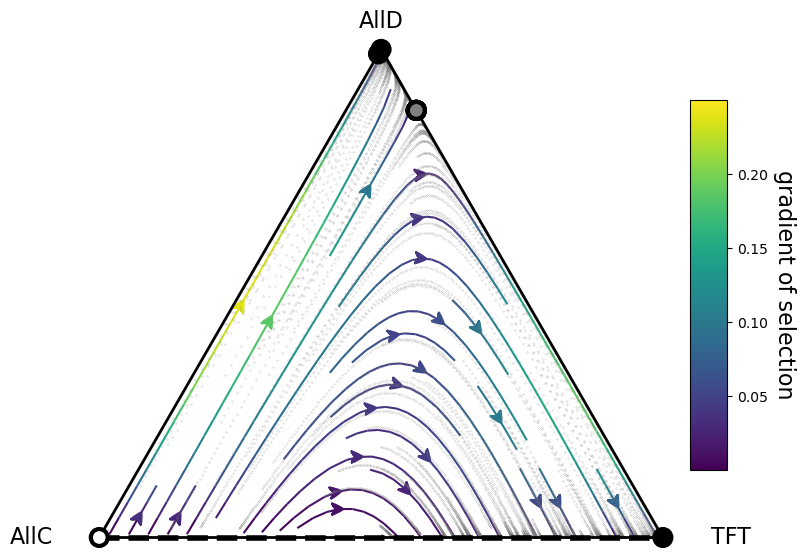

In [10]:
fig, ax = plt.subplots(figsize=(10,8))

simplex, gradients, roots, roots_xy, stability = plot_replicator_dynamics_in_simplex(game.expected_payoffs(), ax=ax)

plot = (simplex.draw_triangle()
           .draw_gradients(density=1)
           .add_colorbar(label='gradient of selection')
           .add_vertex_labels(strategy_labels, epsilon_bottom=0.12)
           .draw_stationary_points(roots_xy, stability)
           .draw_scatter_shadow(lambda u, t: egt.analytical.replicator_equation(u, game.expected_payoffs()), 100, color='gray', marker='.', s=0.1)
          )

ax.axis('off')
ax.set_aspect('equal')

plt.xlim((-.05,1.05))
plt.ylim((-.02, simplex.top_corner + 0.05))
plt.show()

In [11]:
nb_rounds = 100

In [12]:
game = egt.games.NormalFormGame(nb_rounds, A, strategies)

In [13]:
game.expected_payoffs()

array([[ 2.  , -1.  ,  2.  ],
       [ 3.  ,  0.  ,  0.03],
       [ 2.  , -0.01,  2.  ]])

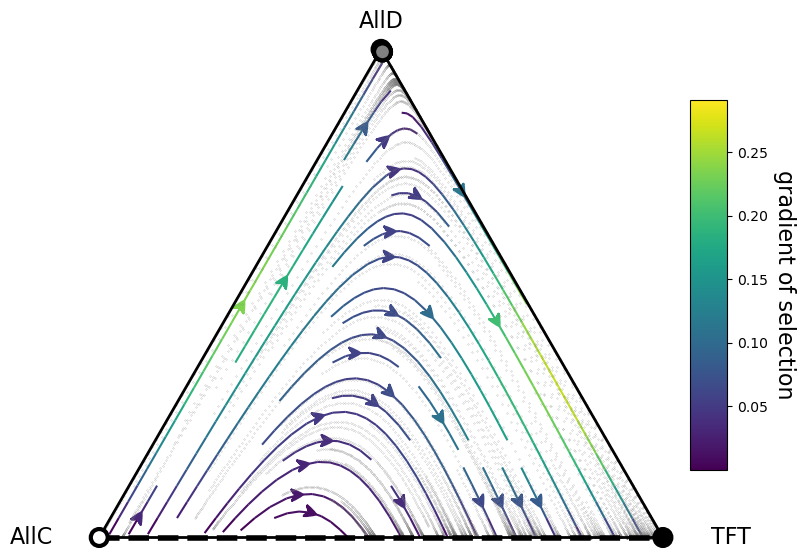

In [14]:
fig, ax = plt.subplots(figsize=(10,8))

simplex, gradients, roots, roots_xy, stability = plot_replicator_dynamics_in_simplex(game.expected_payoffs(), ax=ax)

plot = (simplex.draw_triangle()
           .draw_gradients(density=1)
           .add_colorbar(label='gradient of selection')
           .add_vertex_labels(strategy_labels, epsilon_bottom=0.12)
           .draw_stationary_points(roots_xy, stability)
           .draw_scatter_shadow(lambda u, t: egt.analytical.replicator_equation(u, game.expected_payoffs()), 100, color='gray', marker='.', s=0.1)
          )

ax.axis('off')
ax.set_aspect('equal')

plt.xlim((-.05,1.05))
plt.ylim((-.02, simplex.top_corner + 0.05))
plt.show()

## Part 2: Finite populations - small mutation limit

In [15]:
strategies = [egt.behaviors.NormalForm.TwoActions.Cooperator(), 
              egt.behaviors.NormalForm.TwoActions.Defector(), 
              egt.behaviors.NormalForm.TwoActions.TFT(), 
              egt.behaviors.NormalForm.TwoActions.GRIM(), 
              egt.behaviors.NormalForm.TwoActions.Detective()]

In [16]:
strategy_labels = [strategy.type().replace("NFGStrategies::", '') for strategy in strategies]

In [17]:
nb_rounds = 100

In [18]:
game = egt.games.NormalFormGame(nb_rounds, A, strategies)

In [19]:
game.expected_payoffs()

array([[ 2.  , -1.  ,  2.  ,  2.  , -0.91],
       [ 3.  ,  0.  ,  0.03,  0.03,  0.09],
       [ 2.  , -0.01,  2.  ,  2.  ,  1.98],
       [ 2.  , -0.01,  2.  ,  2.  ,  0.07],
       [ 2.97, -0.03,  1.98,  0.03,  1.98]])

### Part 2.1: Effect of $\beta$

Investigate the effect of $\beta$ in the fixation probabilities and stationary distribution

In [20]:
Z = 100
beta = 0.1

evolver = egt.analytical.StochDynamics(len(strategies), game.expected_payoffs(), Z)

In [21]:
transition_matrix,fixation_probabilities = evolver.transition_and_fixation_matrix(beta)
stationary_distribution = egt.utils.calculate_stationary_distribution(transition_matrix)

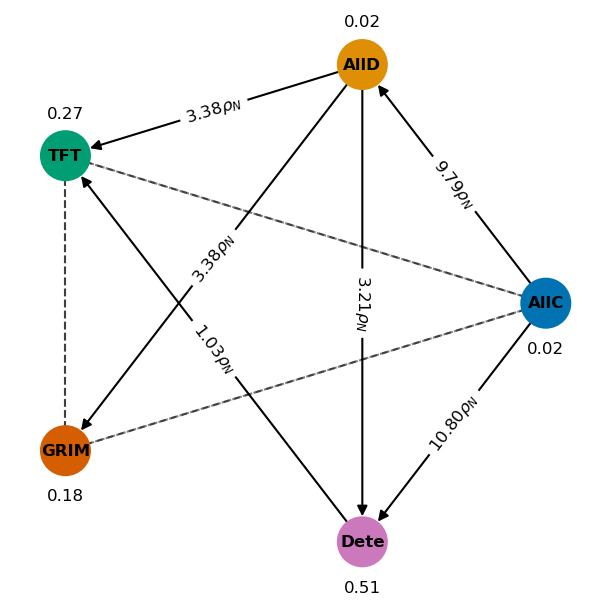

In [22]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
G = egt.plotting.draw_stationary_distribution(strategy_labels,
                                              1/Z, fixation_probabilities, stationary_distribution,
                                              node_size=600, 
                                              font_size_node_labels=8,
                                              font_size_edge_labels=8,
                                              font_size_sd_labels=8,
                                              edge_width=1,
                                              min_strategy_frequency=-0.01, 
                                              ax=ax)
plt.axis('off')
plt.show() # display

### Part 2.2 Effect of $Z$

Study the effect of $Z$

### Part 2.3: Which strategy(s) are dominant


## Part 3: Monte Carlo simulations

Here is an example on how to estimate the stationary distribution with mutation using egttools. You should obtain a similar result using your own implementation

In [23]:
strategies = [egt.behaviors.NormalForm.TwoActions.Cooperator(), 
              egt.behaviors.NormalForm.TwoActions.Defector()]

In [24]:
game = egt.games.NormalFormGame(nb_rounds, A, strategies)

In [25]:
Z = 50
beta = 1
mu = 1e-3
transitory = 1000
nb_generations = 1000000
nb_runs = 10

In [26]:
evolver = egt.numerical.PairwiseMoran(Z, game, 100000)

In [27]:
sd = evolver.estimate_stationary_distribution_sparse(nb_runs, nb_generations, transitory, beta, mu)

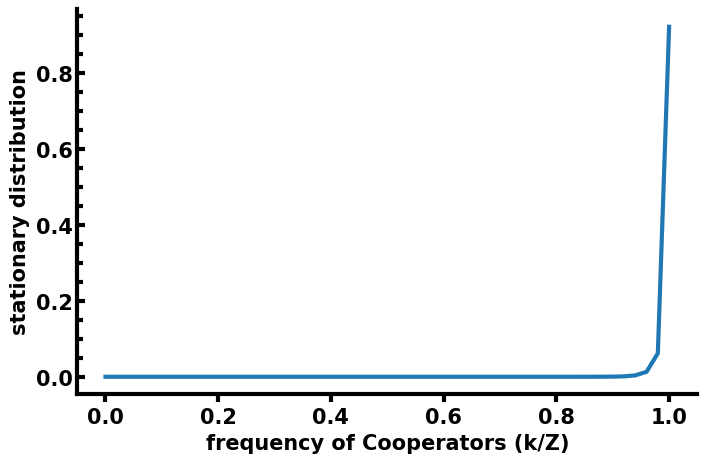

In [28]:
sns.set_context("notebook", rc={"lines.linewidth": 3, "axes.linewidth": 3})

fix, ax = plt.subplots(figsize=(8, 5))

ax.plot(np.arange(0, Z+1)/Z, sd.toarray()[0])
ax.set_ylabel('stationary distribution', fontsize=15, fontweight='bold')
ax.set_xlabel('frequency of Cooperators (k/Z)', fontsize=15, fontweight='bold')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='x', which='both', labelsize=15, width=3)
ax.tick_params(axis='y', which='both', direction='in', labelsize=15, width=3)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')

sns.despine()

### This is an example on how the same could be done for 3 strategies

You don't need to do this in your assignment

In [29]:
from egttools.plotting import Simplex2D

In [30]:
strategies = [egt.behaviors.NormalForm.TwoActions.Defector(), 
              egt.behaviors.NormalForm.TwoActions.Detective(), 
              egt.behaviors.NormalForm.TwoActions.TFT()]

In [31]:
strategy_labels = [strategy.type().replace("NFGStrategies::", '') for strategy in strategies]

In [32]:
game = egt.games.NormalFormGame(nb_rounds, A, strategies)

In [33]:
mu=1/Z

In [34]:
analytical_evolver = egt.analytical.StochDynamics(3, game.expected_payoffs(), Z, mu=mu)
sd_analytical = analytical_evolver.calculate_stationary_distribution(beta)

In [35]:
evolver = egt.numerical.PairwiseMoran(Z, game, 100000)
sd_estimated = evolver.estimate_stationary_distribution_sparse(nb_runs, 10000000, transitory, beta, mu).toarray()[0,:]

(-0.02, 0.9160254037844386)

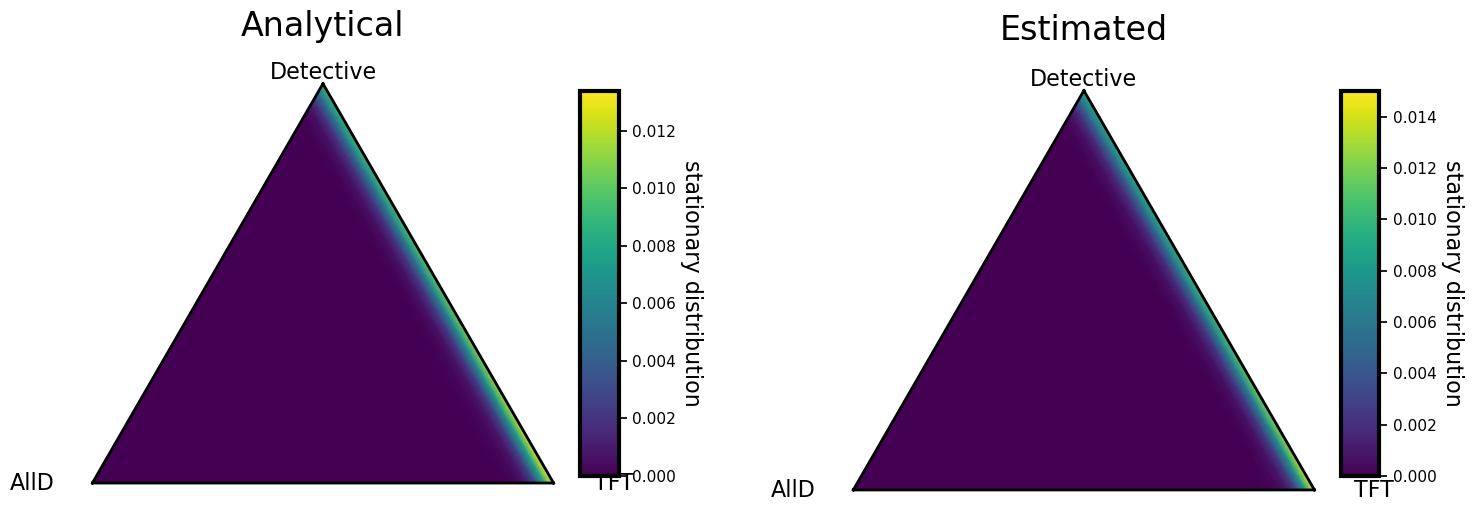

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(18,10))


plot = (Simplex2D(discrete=True, size=Z, nb_points=Z+1).add_axis(ax=axes[0])
           .draw_triangle()
           .add_vertex_labels(strategy_labels, epsilon_bottom=0.13, epsilon_top=0.03)
           .draw_stationary_distribution(sd_analytical, alpha=1, shrink=0.5,
                                         edgecolors='gray', cmap='viridis', shading='gouraud', zorder=0)
          )

axes[0].set_title("Analytical", pad=20, fontsize=24)
axes[0].axis('off')
axes[0].set_aspect('equal')

plot = (Simplex2D(discrete=True, size=Z, nb_points=Z+1).add_axis(ax=axes[1])
           .draw_triangle()
           .add_vertex_labels(strategy_labels, epsilon_bottom=0.13, epsilon_top=0.03)
           .draw_stationary_distribution(sd_estimated, alpha=1, shrink=0.5,
                                         edgecolors='gray', cmap='viridis', shading='gouraud', zorder=0)
          )

axes[1].set_title("Estimated", pad=20, fontsize=24)
axes[1].axis('off')
axes[1].set_aspect('equal')

plt.xlim((-.05,1.05))
plt.ylim((-.02, simplex.top_corner + 0.05))

## Part 4: Interactions in a scale-free network

### How does the evolutionary process looks like in a finite population?

In [37]:
nb_states = egt.calculate_nb_states(Z, 3)
initial_state = egt.sample_simplex(np.random.randint(0, nb_states), Z, 3)
evolution_run = evolver.run(10000, beta, initial_state)

In [38]:
colors = sns.color_palette("viridis", 3)

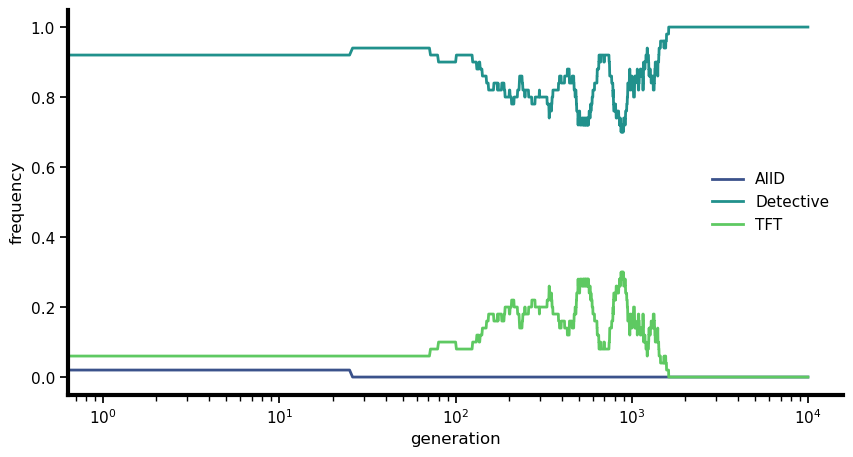

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))

for i, color in enumerate(colors):
    ax.plot(evolution_run[:, i]/Z, color=color, lw=2)
    
ax.legend(strategy_labels, frameon=False)

ax.set_ylabel('frequency')
ax.set_xlabel('generation')
ax.set_xscale('log')
sns.despine()

### Now what happens if the interactions occur in complex networks?

Algorithm:

1. Each player is playing an Iterated Prisoner's Dilemma with each of their neighbours (same payoff matrix as at the begginning of the notebook), playing the same strategy with each one of them. The total payoff is calculated as a sum of the payoffs received from playing all the games.  

2. Initially consider only 3 strategies, e.g., AllD, AllC, Detective.

3. The update mechanism is imitation: in each round (synchronously), each individual i chooses randomly a neighbour j and with probability $p_{ij}=(1+e^{\beta*(\Pi_{i} - \Pi_{j})})^{-1}$ they change their strategy to that of the neighbour

4. Updates are made syncrhonously: you need to keep 2 networks, one for the updated network and one for the old network. Iterate over all nodes and produce the desired update.

4. Let's only scale-free graphs with 900 nodes and an average connectivity of 4.

5. Place randomly 300 individuals of each strategy in the network.

Answer the following:

a) How does the result differ from the well-mixed case? What could be the causes?

b) If you repeat the simulations more than once for different realizations of the network (you generate the network again), do you obtain the same results? Why?



In [40]:
import networkx as nx

In [41]:
Z = 900
k_mean = 4

In [42]:
G_sf = nx.barabasi_albert_graph(Z, k_mean)

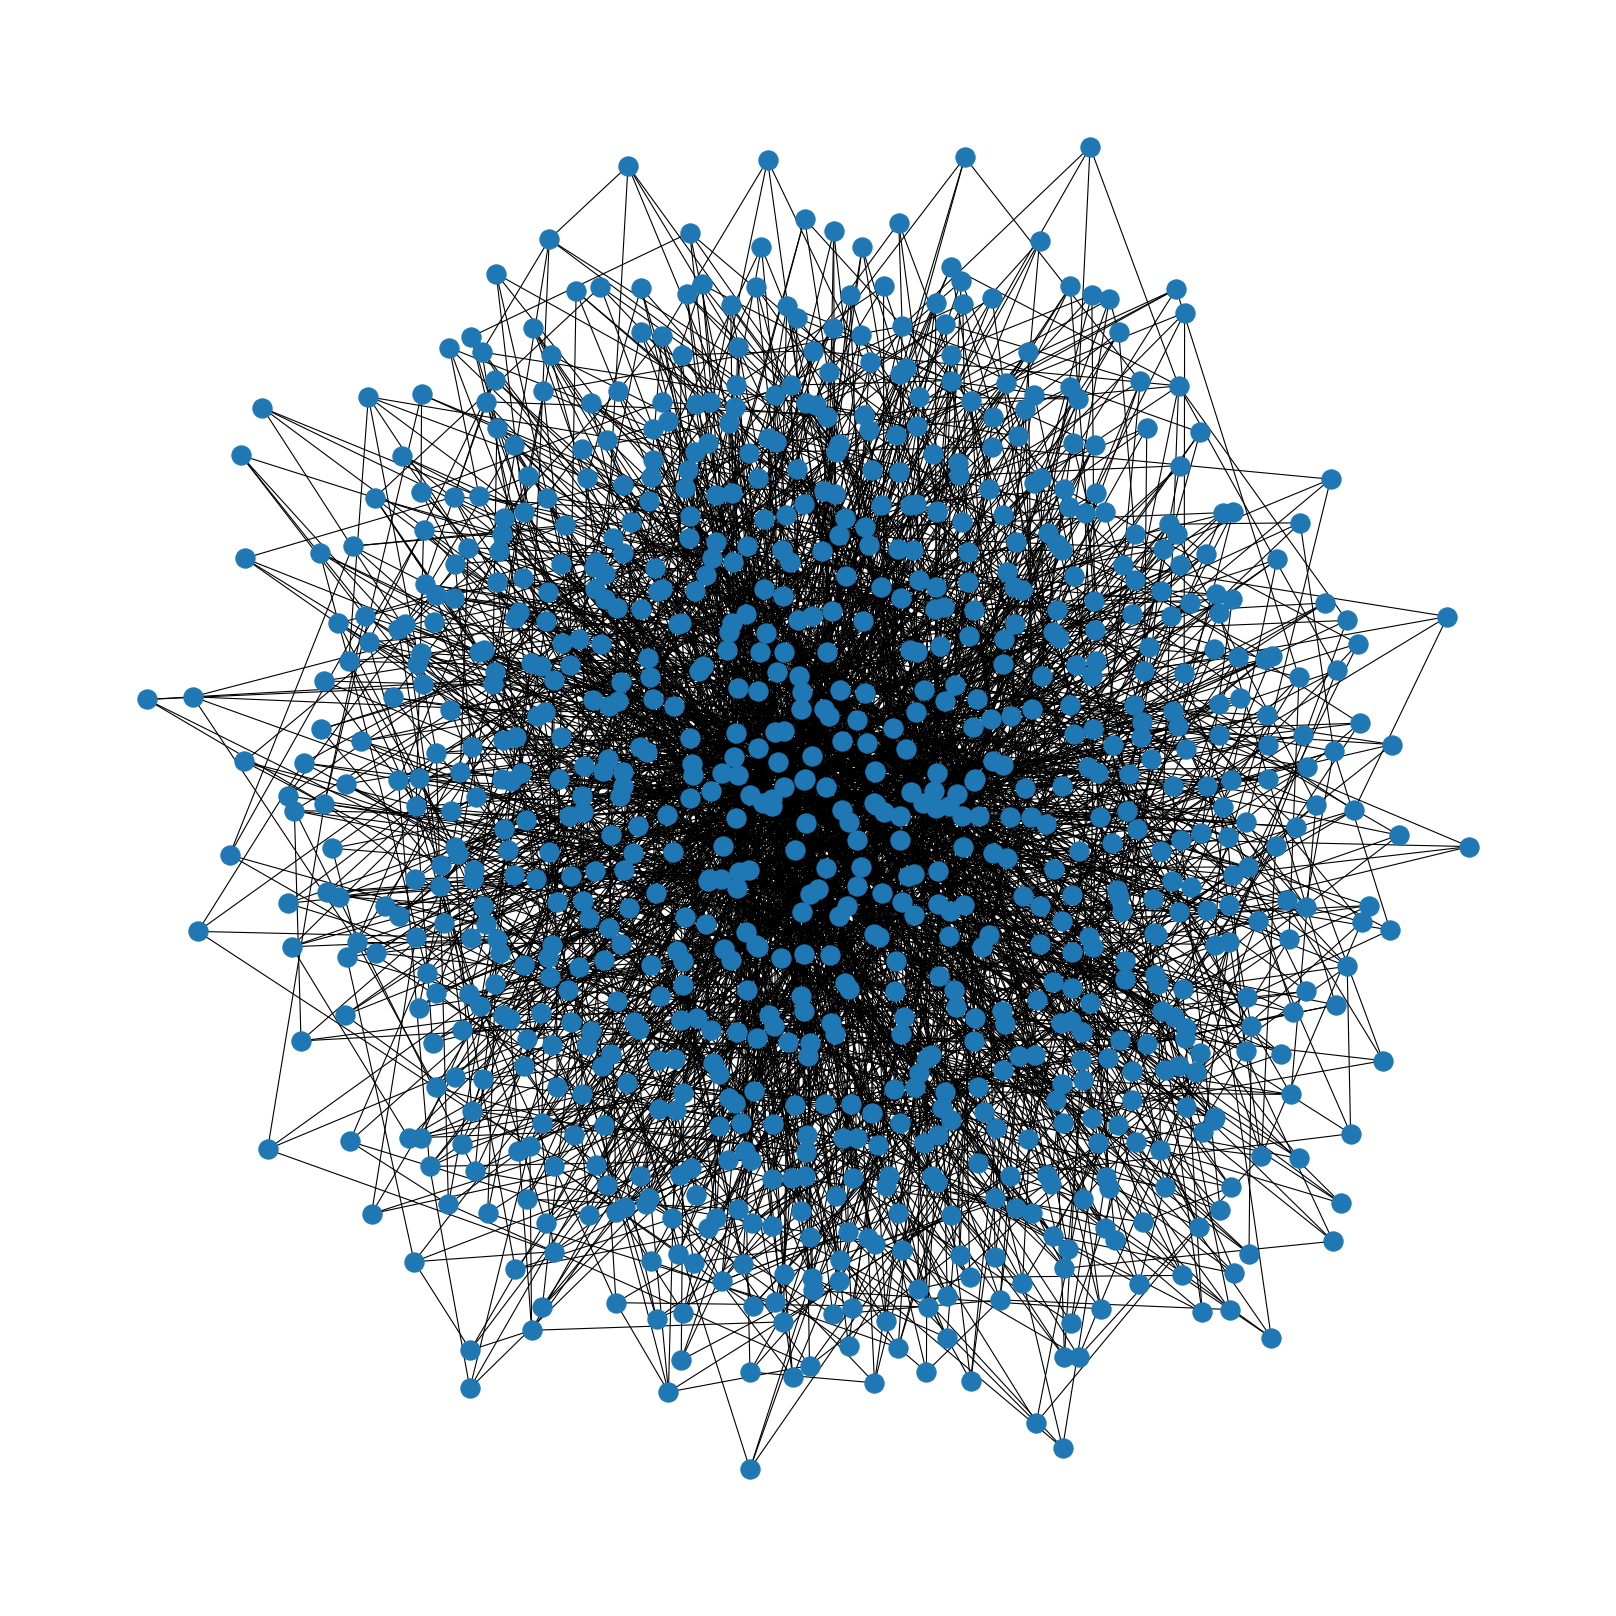

In [47]:
plt.figure(num=None, figsize=(20, 20), dpi=80)

nx.draw(G_sf, pos=nx.spring_layout(G_sf))
plt.show()

### You can get the neighbours of a node with:

In [53]:
node = 2
neighbours = list(G_sf[i].keys())

In [54]:
neighbours

[0, 6, 9, 17, 27, 28, 32, 52, 118, 159, 218, 343, 461, 484, 654, 763, 800]

### You can get the list of nodes with:

In [55]:
G_sf.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

### Example implementation for 2 strategies

In [ ]:
def simulate_evolution_on_graph(graph, beta, population_size, nb_generations):
    """
    Population size must be a multiple of 2
    """

    # First let's generate an array with 20 individuals of the 3 types (so 60 individuals in total)
    population = [0, 1] * (population_size // 2)
    
    # Then we reshufle so that there is a random ordering
    for _ in range(5):
        np.random.shuffle(population)
        
    population_next = population.copy()
    
    payoffs = {i: 0 for i in range(population_size)}
    
    cooperation_rate = np.zeros((nb_generations + 1,))
    
    for i in range(nb_generations + 1):
        cooperation_rate[i] = np.sum(population)
        # calculate payoffs
        for i in range(Z):
            payoffs[i] = 0
            for neighbour in graph[i].keys():
                payoffs[i] += A[population[i], population[neighbour]]
        
        # update
        for i in range(Z):
            neighbours = list(graph[i].keys())
            birth = np.random.choice(neighbours)
            if np.random.rand() < fermi(beta, payoffs[i], payoffs[birth]):
                population_next[i] = population[birth]
        
        population[:] = population_next[:]
        cooperation_rate[i]
    return cooperation_rate